In [1]:
import matplotlib.pyplot as plt
import numpy as np
import load_data
import Zuschneiden
import Features
import get_classes
import cluster_representatives
from index_calculation import IndexClass
import pickle

# load Data
with open('data/class_features.pkl', 'rb') as class_features_file:
    class_features = pickle.load(class_features_file)
    
with open('data/class_std.pkl', 'rb') as class_std_file_file:
    class_std = pickle.load(class_std_file_file)

with open('data/class_index_models.pkl', 'rb') as class_index_models_file:
    class_index_models = pickle.load(class_index_models_file)

with open('data/index_matrix.pkl', 'rb') as index_matrix_file:
    index_matrix = pickle.load(index_matrix_file)

# generate an index object
index_object = IndexClass(index_matrix)

In [2]:
# load initial data and calculate sequences
matrix,static_features,kopfzeile=load_data.load_matrix(r"..\CSV_SDMflex\SDMflex_V2_Anwendung_final.csv")   # load learning Data
Schnitt = Zuschneiden.Sectioning(matrix,kopfzeile,G=1, c=True)   # calculate sequences
Zuschnitte = Features.region_feature(matrix,Schnitt,kopfzeile,static_features)   # calculate features

In [3]:
# get feature vector for segmentation
features=[]
for i in range(len(Zuschnitte)):
    # Used features are distance (x,y,z), average spindle speed and duration (spindlespeed is diveded by 6 due to recording)
    features += [(Zuschnitte[i][1][0], Zuschnitte[i][1][1],Zuschnitte[i][1][2], Zuschnitte[i][1][4]/6, Zuschnitte[i][1][5])]
features = np.array(features)

# inline segmentation
inline_lables = get_classes.inline_class(features, class_features, class_std)

In [4]:
import math
# Calculation of the values for each Sequence and addit to the index_matrix
class_rep, class_len_rep, class_nrs_inline = cluster_representatives.get_cluster_ts_inline(Zuschnitte, inline_lables)  # get the sorted representative cluster timeseries (cluster --> source --> all ts)

index = np.linspace(kopfzeile.index('Speed_SP')+1, len(kopfzeile)-1, len(kopfzeile) - kopfzeile.index('Speed_SP') - 1).astype(int)   # get relevant indices

# Update the index-matrix based on the current metric
for i in range(len(class_nrs_inline)):
    class_nr = class_nrs_inline[i]

    for sig_index in index:
        for nr_ts in range(len(class_rep[i][sig_index])):

            index_matrix[class_nr][sig_index - kopfzeile.index('Speed_SP') - 1] += [class_index_models[class_nr][sig_index  - kopfzeile.index('Speed_SP') - 1].get_index(class_rep[i][sig_index][nr_ts], 'dist_to_mean')]

               
# TEST for axis indices: Update the index-matrix based on the current metric
vel = np.linspace(0,2,100)
for t in 1*(1*(vel-1)**5+1+vel):

    for i in range(len(class_nrs_inline)):
        class_nr = class_nrs_inline[i]

        for sig_index in index:
            for nr_ts in range(len(class_rep[i][sig_index])):

                index_matrix[class_nr][sig_index - kopfzeile.index('Speed_SP') - 1] += [class_index_models[class_nr][sig_index  - kopfzeile.index('Speed_SP') - 1].get_index(class_rep[i][sig_index][nr_ts], 'dist_to_mean')  + t]

In [5]:
# update the index object with the current data
index_object.update_index(index_matrix)

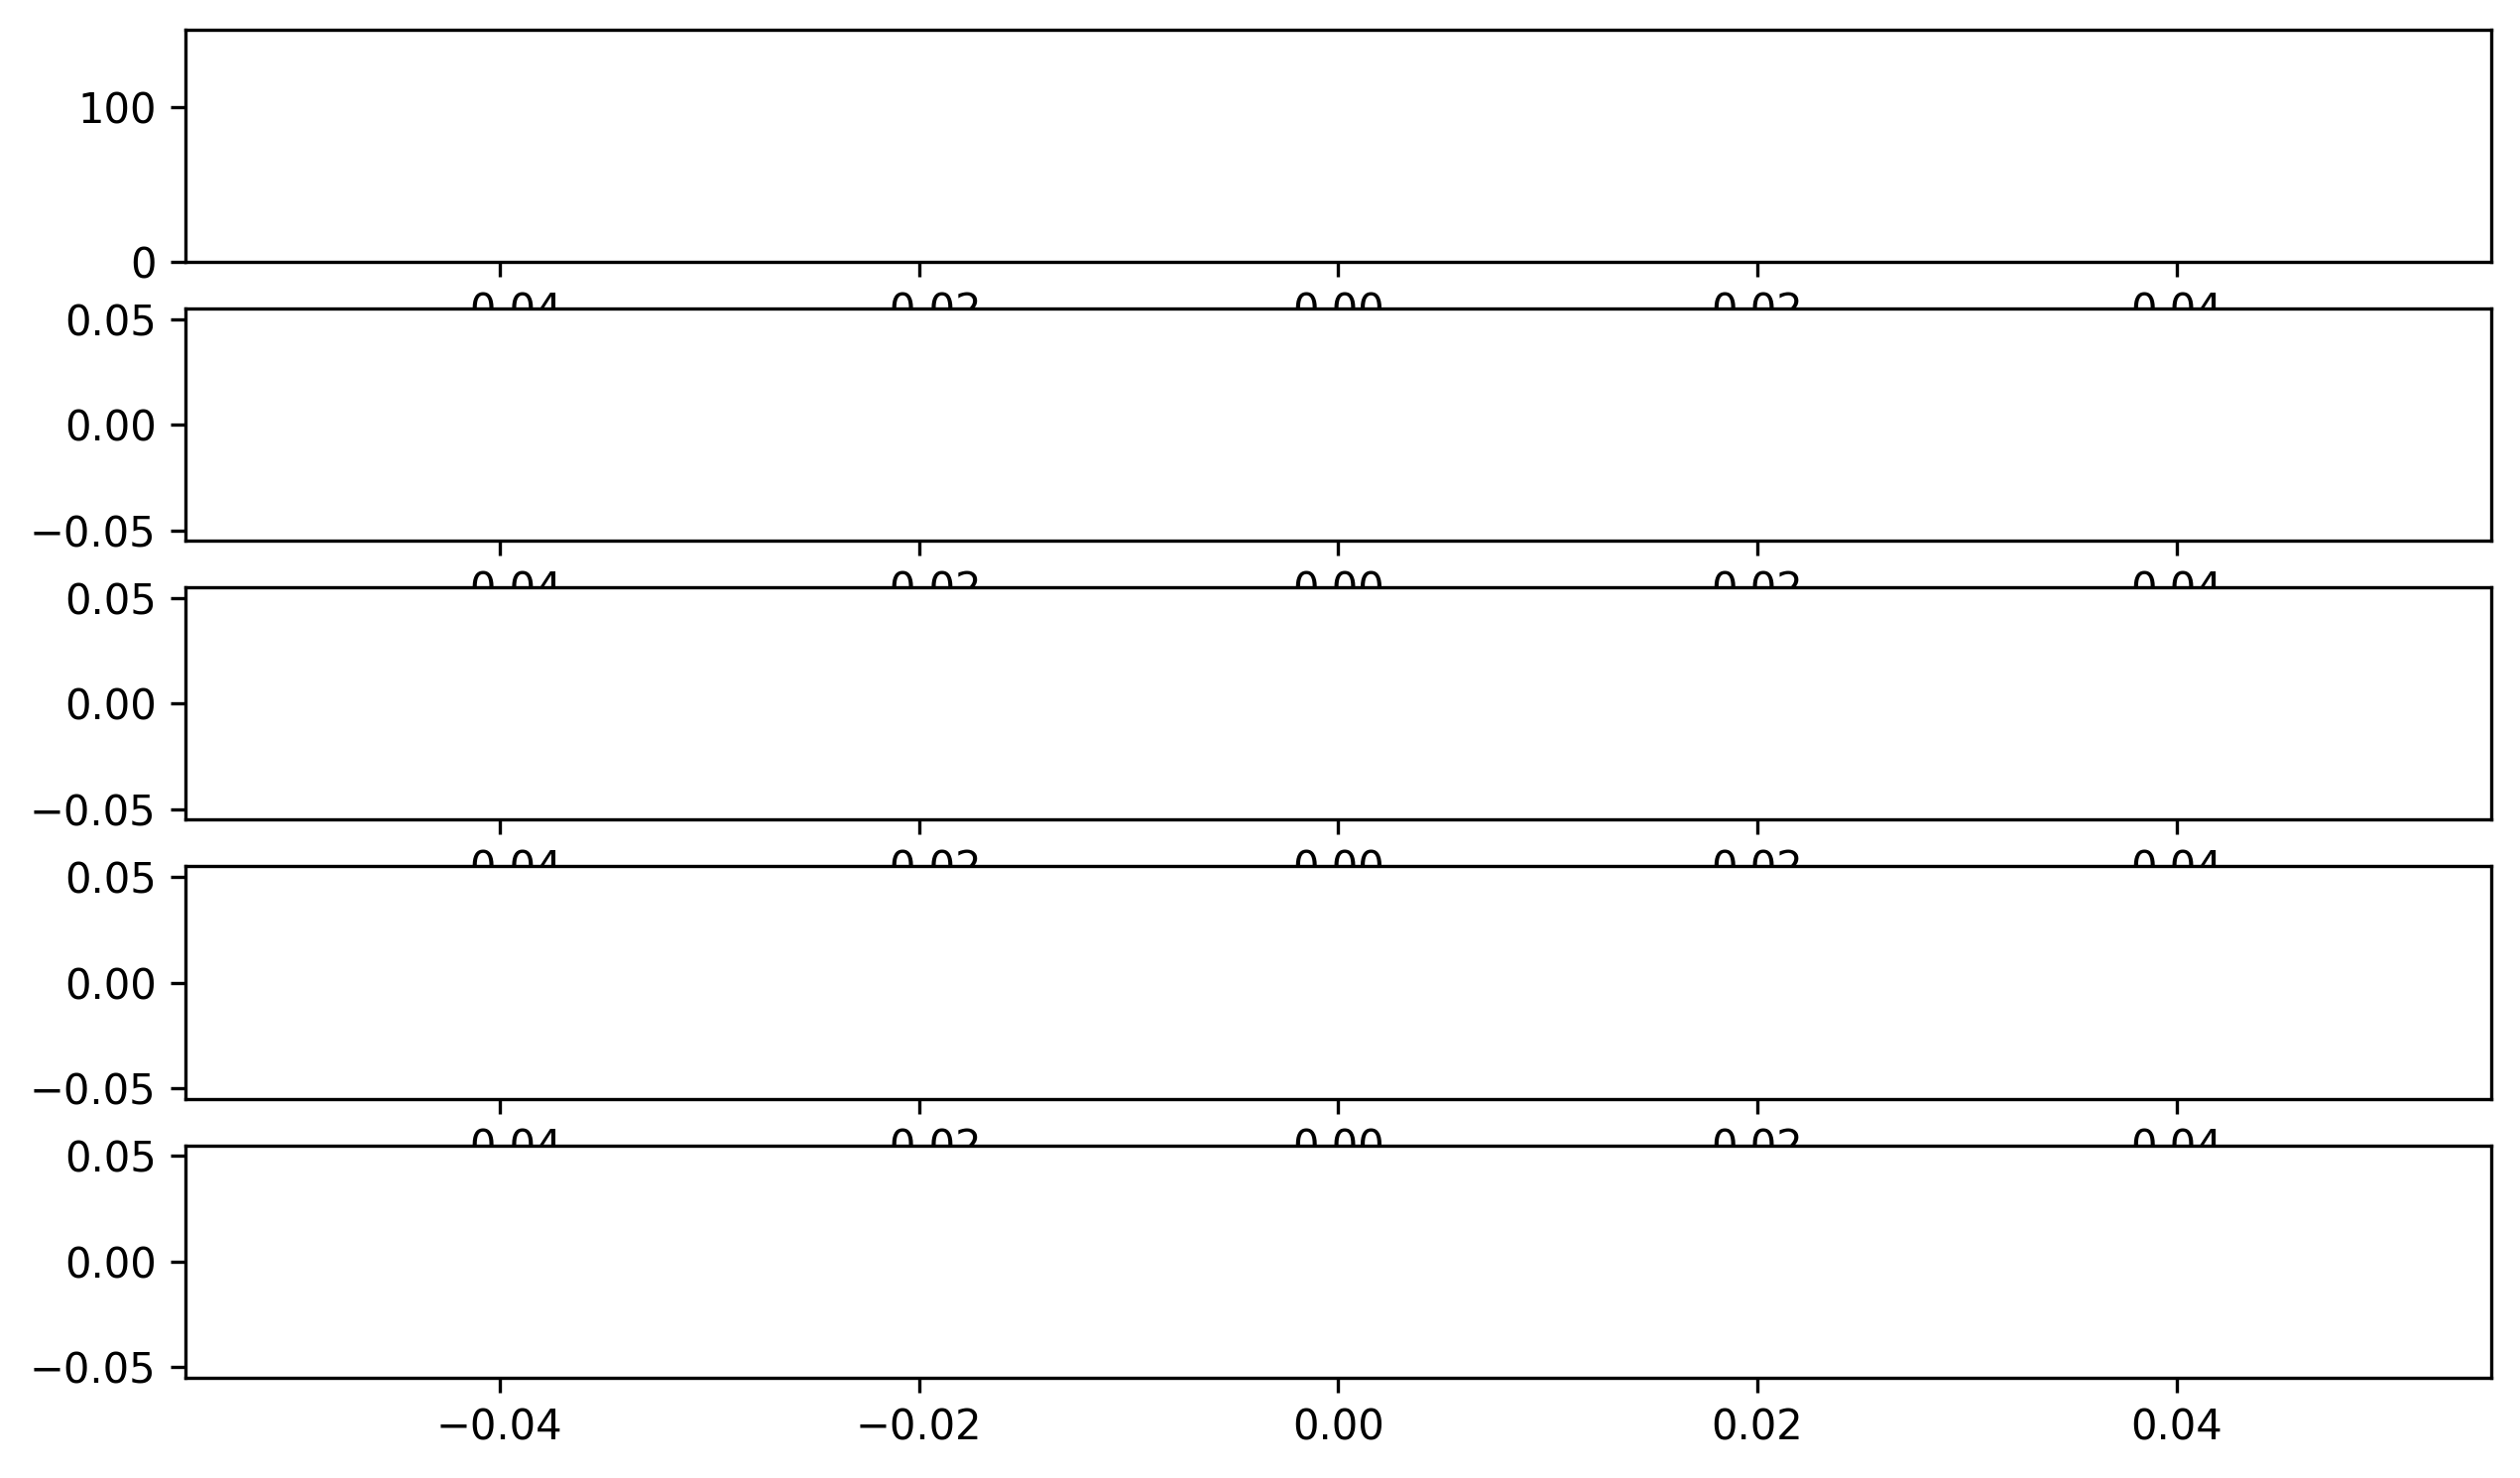

In [6]:
# Teest for componnet wear detection as percentage
fig, ax = plt.subplots(5, figsize=(10, 6), dpi=300)
c=0
t0=[index_object.get_wear_percentage_tool()[c][i] for i in range(len(index_object.get_wear_percentage_tool()[c])) if not index_object.get_wear_percentage_tool()[c][i]=='nan']
ax[0].plot(t0)
ax[0].set_ylim(0,150)
t1=[index_object.get_wear_percentage_x()[c][i] for i in range(len(index_object.get_wear_percentage_x()[c])) if not index_object.get_wear_percentage_x()[c][i]=='nan']
ax[1].plot(t1)
t2=[index_object.get_wear_percentage_y()[c][i] for i in range(len(index_object.get_wear_percentage_y()[c])) if not index_object.get_wear_percentage_y()[c][i]=='nan']
ax[2].plot(t2)
t3=[index_object.get_wear_percentage_z()[c][i] for i in range(len(index_object.get_wear_percentage_z()[c])) if not index_object.get_wear_percentage_z()[c][i]=='nan']
ax[3].plot(t3)
t4=[index_object.get_wear_percentage_spindle()[c][i] for i in range(len(index_object.get_wear_percentage_spindle()[c])) if not index_object.get_wear_percentage_spindle()[c][i]=='nan']
ax[4].plot(t4)

0 0 0 0


ZeroDivisionError: division by zero

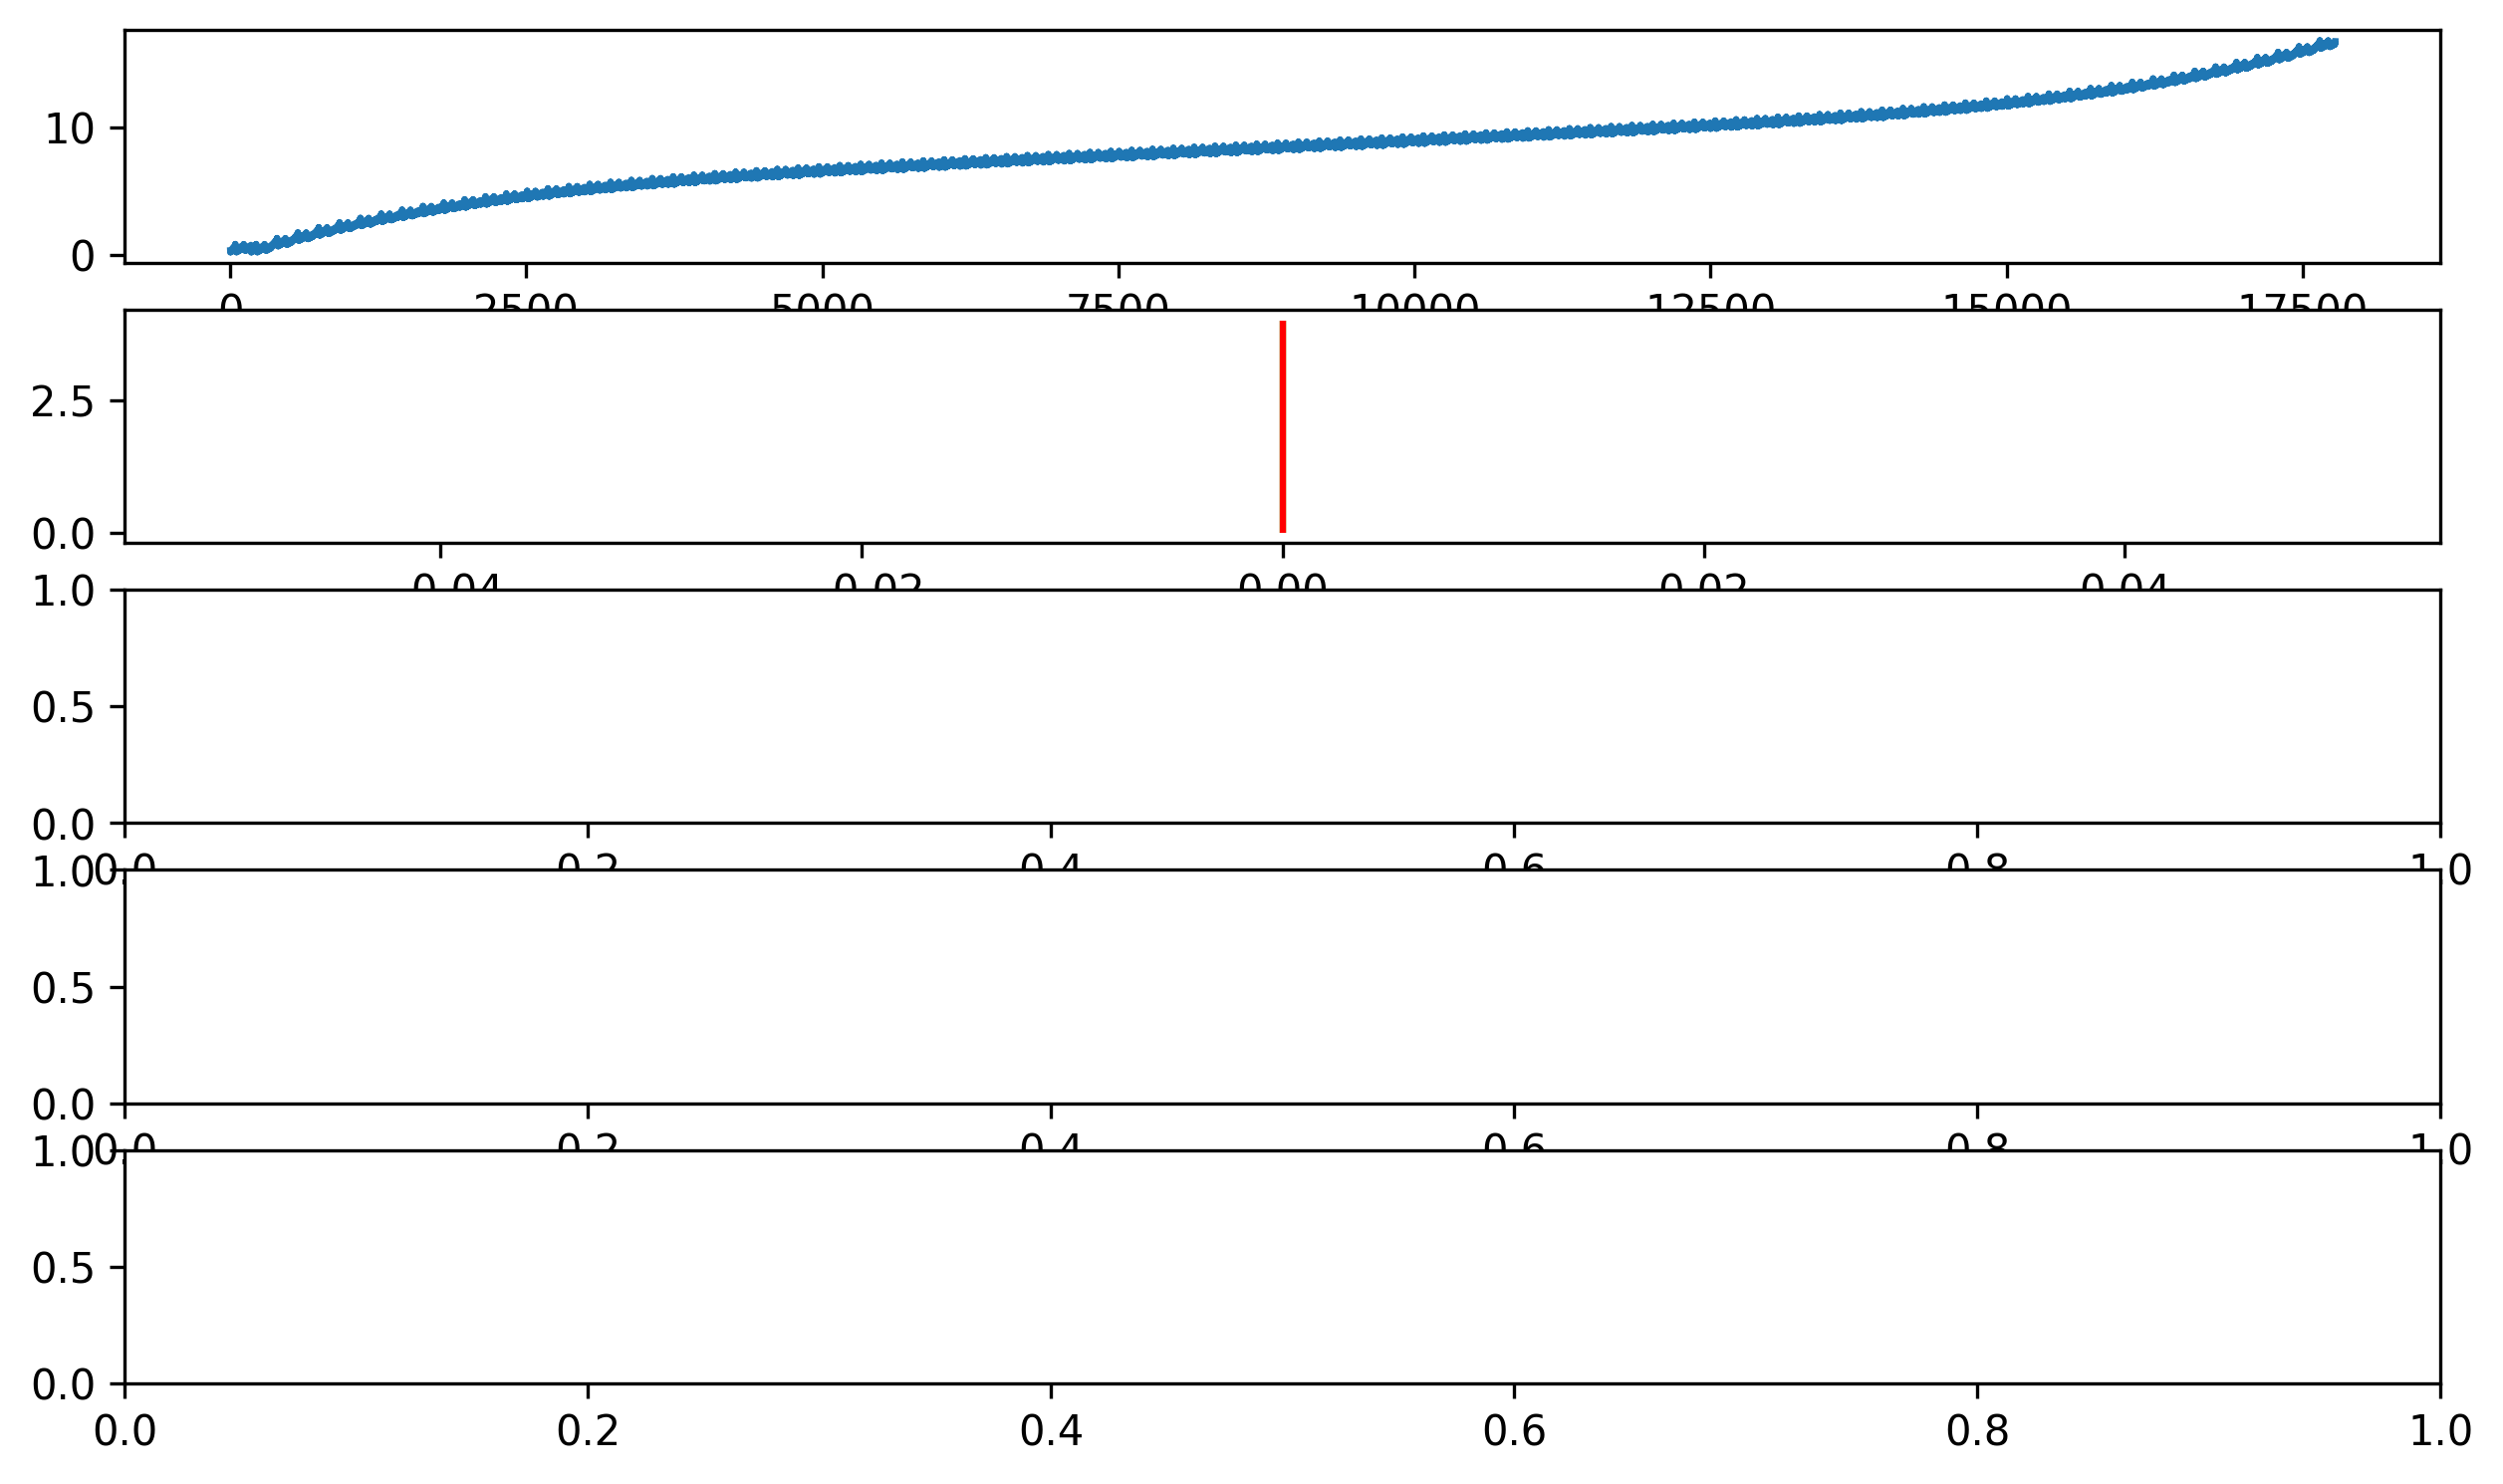

In [7]:
# test of the component indices with thresholds
fig, ax = plt.subplots(5, figsize=(10, 6), dpi=300)
c=0
ax[0].plot(np.array(index_object.get_index_tool()[c])[:])


# x axis
a4=[sum(index_object.get_index_x()[c][i-5:i])/5 for i in range(len(index_object.get_index_x()[c][:]))]
a4=[max([a4[i-ii]- a4[i-ii-1]  for ii in   range(5)]) for i in range(len(a4[:]))]
a4_max=[max([a4[i-ii]- a4[i-ii-1]  for ii in   range(5)]) for i in range(10,len(a4[:]))]
a4_max=[sum(a4_max[i-10:i])/10 for i in range(len(a4_max))][:]
a4_min=[min([a4[i-ii]- a4[i-ii-1]  for ii in   range(10)]) for i in range(10,len(a4[:]))]
a4_min=[sum(a4_min[i-10:i])/10 for i in range(len(a4_min))][:]

ax[1].plot(index_object.get_index_x()[c])
p10=0
p50=0
p90=0
for i in range(15,len(a4_min)):
    if a4_min[i]>-0.001 and p10==0:
        p10=i
    elif a4_max[i] > 0 and not p10==0 and p50==0:
        p50=i
    elif a4_max[i] >0.001 and not p50 == 0 and p90==0:
        p90=i


ax[1].vlines(p10,0,4,'g')
ax[1].vlines(p50,0,4,'y')
ax[1].vlines(p90,0,4,'r')

print(len(index_object.get_index_x()[c]), p10,p50,p90)
print(p10/len(index_object.get_index_x()[c]),p50/len(index_object.get_index_x()[c]),p90/len(index_object.get_index_x()[c]))

# y axis
a4=[sum(index_object.get_index_y()[c][i-5:i])/5 for i in range(len(index_object.get_index_y()[c][:]))]
a4=[max([a4[i-ii]- a4[i-ii-1]  for ii in   range(5)]) for i in range(len(a4[:]))]
a4_max=[max([a4[i-ii]- a4[i-ii-1]  for ii in   range(5)]) for i in range(10,len(a4[:]))]
a4_max=[sum(a4_max[i-10:i])/10 for i in range(len(a4_max))][:]
a4_min=[min([a4[i-ii]- a4[i-ii-1]  for ii in   range(10)]) for i in range(10,len(a4[:]))]
a4_min=[sum(a4_min[i-10:i])/10 for i in range(len(a4_min))][:]

ax[2].plot(index_object.get_index_y()[c])
p10=0
p50=0
p90=0
for i in range(15,len(a4_min)):
    if a4_min[i]>-0.001 and p10==0:
        p10=i
    elif a4_max[i] > 0 and not p10==0 and p50==0:
        p50=i
    elif a4_max[i] >0.001 and not p50 == 0 and p90==0:
        p90=i


ax[2].vlines(p10,0,4,'g')
ax[2].vlines(p50,0,4,'y')
ax[2].vlines(p90,0,4,'r')

print(len(index_object.get_index_y()[c]), p10,p50,p90)
print(p10/len(index_object.get_index_y()[c]),p50/len(index_object.get_index_y()[c]),p90/len(index_object.get_index_y()[c]))

# z axis
a4=[sum(index_object.get_index_z()[c][i-5:i])/5 for i in range(len(index_object.get_index_z()[c][:]))]
a4=[max([a4[i-ii]- a4[i-ii-1]  for ii in   range(5)]) for i in range(len(a4[:]))]
a4_max=[max([a4[i-ii]- a4[i-ii-1]  for ii in   range(5)]) for i in range(10,len(a4[:]))]
a4_max=[sum(a4_max[i-10:i])/10 for i in range(len(a4_max))][:]
a4_min=[min([a4[i-ii]- a4[i-ii-1]  for ii in   range(10)]) for i in range(10,len(a4[:]))]
a4_min=[sum(a4_min[i-10:i])/10 for i in range(len(a4_min))][:]

ax[3].plot(index_object.get_index_z()[c])

p10=0
p50=0
p90=0
for i in range(15,len(a4_min)):
    if a4_min[i]>-0.001 and p10==0:
        p10=i
    elif a4_max[i] > 0 and not p10==0 and p50==0:
        p50=i
    elif a4_max[i] >0.001 and not p50 == 0 and p90==0:
        p90=i


ax[3].vlines(p10,0,4,'g')
ax[3].vlines(p50,0,4,'y')
ax[3].vlines(p90,0,4,'r')

print(len(index_object.get_index_z()[c]), p10,p50,p90)
print(p10/len(index_object.get_index_z()[c]),p50/len(index_object.get_index_z()[c]),p90/len(index_object.get_index_z()[c]))

# spondle
a4=[sum(index_object.get_index_spindle()[c][i-5:i])/5 for i in range(len(index_object.get_index_spindle()[c][:]))]
a4=[max([a4[i-ii]- a4[i-ii-1]  for ii in   range(5)]) for i in range(len(a4[:]))]
a4_max=[max([a4[i-ii]- a4[i-ii-1]  for ii in   range(5)]) for i in range(10,len(a4[:]))]
a4_max=[sum(a4_max[i-10:i])/10 for i in range(len(a4_max))][:]
a4_min=[min([a4[i-ii]- a4[i-ii-1]  for ii in   range(10)]) for i in range(10,len(a4[:]))]
a4_min=[sum(a4_min[i-10:i])/10 for i in range(len(a4_min))][:]
ax[4].plot(index_object.get_index_spindle()[c])

p10=0
p50=0
p90=0
for i in range(15,len(a4_min)):
    if a4_min[i]>-0.001 and p10==0:
        p10=i
    elif a4_max[i] > 0 and not p10==0 and p50==0:
        p50=i
    elif a4_max[i] >0.001 and not p50 == 0 and p90==0:
        p90=i

ax[4].vlines(p10,0,4,'g')
ax[4].vlines(p50,0,4,'y')
ax[4].vlines(p90,0,4,'r')

print(len(index_object.get_index_spindle()[c]), p10,p50,p90)
print(p10/len(index_object.get_index_spindle()[c]),p50/len(index_object.get_index_spindle()[c]),p90/len(index_object.get_index_spindle()[c]))